In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

레퍼런스
1. [유의성검정](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=modernyoon&logNo=221581004731)
2. [부호순위검정](https://lovelydiary.tistory.com/369)
3. [R TSclust의 diss.ACF](https://search.r-project.org/CRAN/refmans/TSclust/html/diss.ACF.html)
4. Comparison of time series clustering methods and application to power consumption pattern clustering(2020) 해당 논문 2,3페이지
5. [R tsclust 사용예시](http://bigdata.emforce.co.kr/index.php/2021021901/)


## 통계파트 1번
공장에서는 진공관 수명이 1만 시간이라고 주장하여 품질관리팀에서 12개 샘플을 뽑았음 유의수준 5%에서 부호 검정하시오
1. 귀무가설, 연구가설 세우기  
2. 유효한 데이터의 개수는?  
3. 검정통계량 및 연구가설 채택 여부를 작성하라


In [ ]:
import pandas as pd
import numpy as np
import scipy

df1 = pd.read_csv('/content/drive/MyDrive/data/adp/problem2.csv')
df1.head()

,name,life span
0,sample1,10000
1,sample2,9000
2,sample3,9500
3,sample4,10000
4,sample5,10000


1.   
귀무가설: 진공관의 수명이 1만시간이다. (μ = 10,000, i.e difference = 0)  
연구가설: 진공관의 수명이 1만시간이 아니다. (μ != 10,000 )

2. 샘플의 수 문제로 중심극한정리를 만족하지 않으므로 해당 검정은 비모수 방법인 윌콕슨 부호순위 검정을 이용한다. 각 샘플의 수명에서 10,000을 뺀 값으로 부호순위검정을 통해 실질적으로 새로운 샘플의 mu = 0 을 만족하는지 확인한다. 만약 mu = 0 이라면 원 데이터의 평균이 10,000이라고 말할 수 있다. 
윌콕슨 부호순위 검정은 부호를 기준으로 하기 떄문에 0은 계산에 유의한 데이터가 아니다. 따라서 2번 문제의 답은 각 데이터에 10,000을 뺐을 때 0이 되지 않는 데이터의 개수이다. 
아래 코드와 같이 유효한 데이터는 총 8개임을 알 수 있다. 

In [ ]:
testdata1 = list(df1['life span'] - 10000)
while 0 in testdata1:
  testdata1.remove(0)
len(testdata1)

8

3. 윌콕슨 부호순위 검정을 이용해 유의수준 5%에서 부호순위 검정을 하면, 결과는 다음과 같다. 

In [ ]:
from scipy.stats import wilcoxon
w, p = wilcoxon(df1['life span'] - 10000)
w,p

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


(8.5, 0.18289327757982765)

양측검정을 수행했을 시 p 값은 약 0.18 정도로 유의수준 5%에서 귀무가설을 채택한다. 따라서 해당 공정의 진공관 수명은 10,000이라고 말할 수 있다. 

## 통계파트 2번 (시계열)
코로나 시계열 데이터
1. ACF 함수에 따른 거리 계산
2. 계층적 군집 분석을 위해 덴드로그램 작성

Autocorrelation-based dissimilarity 이라는 키워드의 문제인데 자료가 많진 않네요.. 


** R에는 TSdist라는 패키지 안에 diss.ACF 메서드가 ACF기반 Distance를 자동으로 구해줍니다. Python은 rpy2라는 패키지를 통해서 R에 있는 패키지를 가져올 순 있는데 이 패키지를 ADP에서 지원해주지 않다보니... 직접 코딩해서 푸는 수 밖에 없는 것 같네요. ADP에서 파이썬 ~~많이~~ 좀 불리한 것 같습니다😠

Types of distances used in clustering
- model-free method
- model-based method
- complexity methods
1. model-free method  
ex) comparing autocorrelation function(ACF): 특정 시점에 두 시계열의 값이 얼마나 가까운지, 그 근사치를 측정함. 두 개 시계열의 모든 시점 조합 사이의 거리를 구함.
2. model-based method
모든 시계열이 모델이나 혼합확률분포 형태를 띤다고 가정함. 예를 들어 두 시계열의 상관관계를 이용한 거리를 계산한 방법이 있다.
3. Complexity-based approach
시계열의 복잡성 정도를 비교한다. 두 시계열이 공유하는 정보의 수준을 고려해서 유사성을 판단한다.  

Autocorrelation based distance   
$d_{ACF}(X,Y) =  \sqrt{ (\hat{p}_{X} - \hat{p}_{Y})^{'} 𝛀  ( \hat{p}_{X} - \hat{p}_{Y})  } $  
<br>   
𝛀는 wegiht matrix로 해당 값을 고려하지 않을 때는 1로 두고 계산하고, 그러한 경우에는 matrix A에 대해 $A^{T} * A$와 같으므로 아래와 같은 식으로 풀 수 있다.  
<br>
$d_{ACF}(X,Y) = \sqrt{ \displaystyle \sum_{i=1}^{L} (\hat{p}_{i,X} - \hat{p}_{i,Y})^{2} }$  
$\hat{p}_{X} 와 \hat{p}_{Y} $ 은 각각 X, Y의 autocorrelation 벡터를 Transpose한 벡터이다. 따라서 1부터 설정된 시차 L번째 까지의 값이 들어있음.
<br>  
위의 정의에 의해 이 문제를 아래 순서로 풀 수 있음.  
1. 각 시계열 데이터를 보고 결측값 문제 해결
2. 그래프를 보고 autocorrelation 벡터에 들어갈 acf lag값을 몇까지 볼건지 결정
3. 1~max.lag까지의 autocorrelation을 구한 벡터를 나라별로 구해놓음
4. 3번 벡터로 hierarchical clustering을 수행



In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/data/adp/problem3_covid.csv')
df2.head()

,location,date,new_cases
0,Austria,2021-01-01,2096.0
1,Austria,2021-01-02,1391.0
2,Austria,2021-01-03,1466.0
3,Austria,2021-01-04,1642.0
4,Austria,2021-01-05,2311.0


In [ ]:
df2.tail()

,location,date,new_cases
12195,Vanuatu,2021-10-28,0.0
12196,Vanuatu,2021-10-29,0.0
12197,Vanuatu,2021-10-30,0.0
12198,Vanuatu,2021-10-31,0.0
12199,Vanuatu,2021-11-01,0.0


In [ ]:
## location별로 데이터 수가 같은지 확인
df2.groupby(['location']).count()

,date,new_cases
location,,
Austria,305,305
Bangladesh,305,305
Bhutan,305,305
Chile,305,305
Colombia,305,305
Costa Rica,305,305
Dominica,305,305
Dominican Republic,305,305
Eswatini,305,305


데이터 개수가 맞지 않는 location은 Guernsey와 Palau 두 곳이다. 결측값 대체해서 푸느냐, 삭제하느냐 두 가지 선택지 중 삭제를 선택했다. 이유는 0으로 대체하면 이상치로 작용해서 Hierarchical Clustering이 제대로 이루어지지 않을 것이고, 회귀 등의 예측방법으로 대체하기에는 관측치가 너무 적음. 

In [ ]:
df2 = df2[(df2['location']!='Guernsey') & (df2['location']!='Palau')]

다음으로 Autocorrelation Vector의 길이를 결정할 lag를 정해야 한다. 일자별로 약 1년 간의 데이터가 존재하기에 7 또는 7*30이 좋지 않을까 생각했으나, tsclust의 max.lag가 50까지인 것을 고려하여 7로 결정한다. 
시계열 그래프를 그려 다시 한 번 확인

In [ ]:
df2['date'] = pd.to_datetime(df2['date'], format = '%Y-%m-%d')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  


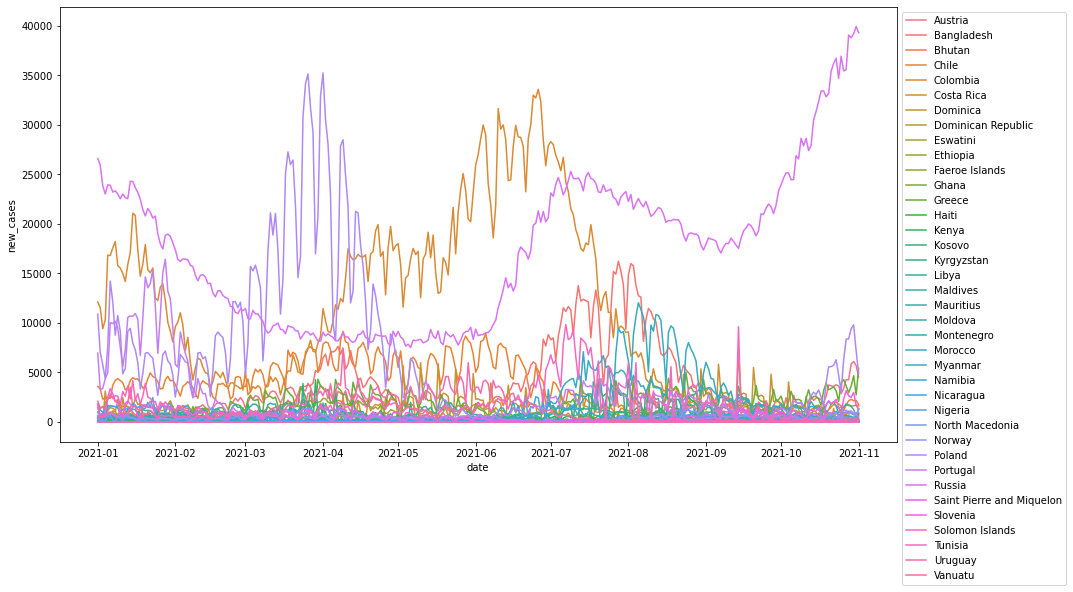

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
ax = sns.lineplot(x='date', y='new_cases', hue='location', data=df2)
plt.locator_params(axis='x', nbins=10)
plt.legend(bbox_to_anchor = (1,1))
plt.show()

그래프 상으로도 시차를 7로 잡는 것이 적당하다는 것을 확인할 수 있다.  
이제 lag = 7로 두고 각 location의 autocorrelation vector를 계산한다.

In [ ]:
# 데이터의 형태를 계산하기 용이하게 바꾸기 
grouper = df2.groupby('location')
df2_ = pd.concat([pd.Series(v['new_cases'].tolist(), name = k) for k, v in grouper], axis = 1)
df2_.head()

,Austria,Bangladesh,Bhutan,Chile,Colombia,Costa Rica,Dominica,Dominican Republic,Eswatini,Ethiopia,Faeroe Islands,Ghana,Greece,Haiti,Kenya,Kosovo,Kyrgyzstan,Libya,Maldives,Mauritius,Moldova,Montenegro,Morocco,Myanmar,Namibia,Nicaragua,Nigeria,North Macedonia,Norway,Poland,Portugal,Russia,Saint Pierre and Miquelon,Slovenia,Solomon Islands,Tunisia,Uruguay,Vanuatu
0,2096.0,990.0,19.0,3591.0,12105.0,0.0,0.0,1433.0,124.0,388.0,0.0,159.0,597.0,16.0,156.0,358.0,122.0,467.0,47.0,0.0,440.0,342.0,1777.0,412.0,604.0,0.0,980.0,414.0,236.0,10896.0,6951.0,26613.0,0.0,1798.0,0.0,1417.0,634.0,0.0
1,1391.0,684.0,21.0,3338.0,11528.0,0.0,0.0,747.0,229.0,397.0,4.0,134.0,262.0,0.0,64.0,0.0,58.0,0.0,30.0,0.0,436.0,267.0,1171.0,574.0,109.0,0.0,576.0,46.0,463.0,7006.0,3241.0,25938.0,0.0,393.0,0.0,1422.0,522.0,0.0
2,1466.0,835.0,6.0,2289.0,9412.0,0.0,0.0,366.0,232.0,573.0,6.0,104.0,390.0,62.0,124.0,463.0,174.0,670.0,33.0,0.0,179.0,339.0,1005.0,729.0,462.0,0.0,917.0,235.0,450.0,5782.0,3384.0,23845.0,0.0,743.0,0.0,1565.0,548.0,0.0
3,1642.0,910.0,18.0,2450.0,10311.0,3115.0,0.0,2043.0,195.0,297.0,2.0,0.0,427.0,50.0,106.0,0.0,0.0,561.0,26.0,4.0,436.0,435.0,656.0,590.0,270.0,0.0,1271.0,105.0,529.0,4385.0,4369.0,23015.0,0.0,772.0,0.0,1252.0,603.0,0.0
4,2311.0,991.0,0.0,2460.0,16835.0,1155.0,0.0,475.0,200.0,322.0,4.0,0.0,927.0,0.0,219.0,368.0,124.0,481.0,37.0,0.0,612.0,424.0,1637.0,649.0,501.0,51.0,1354.0,580.0,935.0,7596.0,4956.0,23955.0,0.0,2512.0,0.0,2265.0,678.0,0.0


In [ ]:
## acf 계산하기
from statsmodels.tsa.stattools import acf
acf(df2_['Austria'], nlags = 7)  ## nlags를 지정하면 지정한 수까지의 autocorrelation을 자동으로 구해줌

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


array([1.        , 0.91960305, 0.85105431, 0.80321808, 0.76386246,
       0.75749033, 0.77297348, 0.789918  ])

In [ ]:
## acf를 직접 함수로 정의하고 개별 값을 구해도 됨 (계산값 완전히 동일)
def personal_acf(series, k):
    mean = series.mean()
    denominator = np.sum(np.square(series-mean))
    numerator = np.sum((series-mean)*(series.shift(k)-mean))
    acf_val = numerator/denominator
    return acf_val

0.7899180022600975

In [ ]:
## location 별 autocorrelation 벡터 생성
df_cluster = pd.DataFrame(columns = list(df2_.columns))
for col in df_cluster.columns:
  df_cluster[col] = acf(df2_[col], nlags = 7)
df_cluster

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


,Austria,Bangladesh,Bhutan,Chile,Colombia,Costa Rica,Dominica,Dominican Republic,Eswatini,Ethiopia,Faeroe Islands,Ghana,Greece,Haiti,Kenya,Kosovo,Kyrgyzstan,Libya,Maldives,Mauritius,Moldova,Montenegro,Morocco,Myanmar,Namibia,Nicaragua,Nigeria,North Macedonia,Norway,Poland,Portugal,Russia,Saint Pierre and Miquelon,Slovenia,Solomon Islands,Tunisia,Uruguay,Vanuatu
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.919603,0.965426,0.404971,0.937209,0.979553,0.187559,0.122646,0.781358,0.820218,0.925311,0.686160,0.186956,0.700962,0.092904,0.822740,0.386680,0.963166,0.523551,0.934121,0.157004,0.885542,0.940588,0.933105,0.972216,0.648255,-0.081411,0.797529,0.799086,0.821435,0.939671,0.944494,0.979211,-0.013769,0.780149,-0.009966,0.707691,0.893337,-0.009221
2,0.851054,0.930580,0.444965,0.860792,0.959433,0.020331,0.119100,0.699239,0.721628,0.873836,0.710250,0.236323,0.562997,0.188725,0.677024,0.382350,0.960068,0.554628,0.926617,0.068096,0.753002,0.923850,0.870180,0.973829,0.736635,-0.081677,0.792440,0.678190,0.737018,0.848592,0.882105,0.957977,0.100639,0.557703,-0.009999,0.708418,0.878473,-0.009251
3,0.803218,0.903649,0.494015,0.818513,0.943796,0.174987,-0.002318,0.709387,0.677337,0.847740,0.584663,0.305757,0.594133,0.117694,0.622662,0.406972,0.950856,0.547963,0.898967,0.139972,0.667341,0.912645,0.844334,0.957790,0.665326,-0.081943,0.827974,0.689977,0.698038,0.802139,0.854912,0.938766,-0.013859,0.513476,-0.010031,0.692422,0.857043,-0.009282
4,0.763862,0.886103,0.354268,0.814239,0.933879,0.172191,0.129099,0.668271,0.677258,0.832921,0.544609,0.313819,0.567467,0.083646,0.618367,0.365760,0.940587,0.529030,0.859778,0.282727,0.659750,0.900863,0.834235,0.955129,0.709807,-0.082209,0.795388,0.681002,0.679191,0.794416,0.837923,0.920349,-0.013904,0.485989,-0.010064,0.670506,0.852344,-0.009312
5,0.757490,0.874632,0.402436,0.844770,0.929708,0.014462,0.096388,0.701668,0.691659,0.841424,0.496580,0.347954,0.516717,0.222823,0.655714,0.562872,0.931666,0.497117,0.840780,0.136118,0.728630,0.892173,0.836794,0.942077,0.785586,-0.034171,0.756610,0.655342,0.679866,0.819599,0.835419,0.902177,-0.013949,0.455829,-0.010097,0.642907,0.859448,-0.009342
6,0.772973,0.872235,0.386444,0.914714,0.928058,0.266074,0.397651,0.732759,0.759552,0.863669,0.399466,0.364162,0.634022,0.284550,0.758697,0.370953,0.917160,0.413358,0.828478,0.130953,0.836960,0.890760,0.871649,0.936400,0.648878,-0.082342,0.794045,0.759077,0.730709,0.886316,0.861000,0.888362,-0.013994,0.604037,-0.010129,0.642802,0.877445,-0.005696
7,0.789918,0.874654,0.480287,0.956108,0.924081,0.778419,0.295431,0.754971,0.782008,0.878608,0.315596,0.256990,0.816770,0.267644,0.828758,0.423271,0.907806,0.818322,0.805673,0.607923,0.905539,0.915175,0.910384,0.924970,0.702668,0.885838,0.800378,0.889777,0.757263,0.924582,0.871848,0.872459,-0.014039,0.741952,-0.010162,0.685664,0.873509,-0.005726


In [ ]:
## 거리를 row 단위로 계산해서 다시 transpose해야 함.. 처음부터 row를 location으로 두면 더 편하게 계산 가능
df2_cluster = df_cluster.transpose()
df2_cluster.set_index(df2_.columns, inplace = True)

In [ ]:
df2_cluster.head()

,0,1,2,3,4,5,6,7
Austria,1.0,0.919603,0.851054,0.803218,0.763862,0.757490,0.772973,0.789918
Bangladesh,1.0,0.965426,0.930580,0.903649,0.886103,0.874632,0.872235,0.874654
Bhutan,1.0,0.404971,0.444965,0.494015,0.354268,0.402436,0.386444,0.480287
Chile,1.0,0.937209,0.860792,0.818513,0.814239,0.844770,0.914714,0.956108
Colombia,1.0,0.979553,0.959433,0.943796,0.933879,0.929708,0.928058,0.924081


In [ ]:
from scipy.spatial import distance_matrix
df2_distance = distance_matrix(df2_cluster, df2_cluster)
df2_distance = pd.DataFrame(df2_distance)
df2_distance.set_index(df2_.columns, inplace = True)
df2_distance.columns = df2_.columns

In [ ]:
df2_distance

,Austria,Bangladesh,Bhutan,Chile,Colombia,Costa Rica,Dominica,Dominican Republic,Eswatini,Ethiopia,Faeroe Islands,Ghana,Greece,Haiti,Kenya,Kosovo,Kyrgyzstan,Libya,Maldives,Mauritius,Moldova,Montenegro,Morocco,Myanmar,Namibia,Nicaragua,Nigeria,North Macedonia,Norway,Poland,Portugal,Russia,Saint Pierre and Miquelon,Slovenia,Solomon Islands,Tunisia,Uruguay,Vanuatu
Austria,0.000000,0.253394,1.031731,0.241875,0.368399,1.667306,1.745036,0.257014,0.233562,0.174469,0.776352,1.408379,0.539508,1.688770,0.324822,1.073831,0.363090,0.750301,0.185888,1.642371,0.241602,0.290147,0.194239,0.396656,0.363949,2.176892,0.143173,0.291025,0.223051,0.190215,0.173997,0.314498,2.137199,0.623303,2.169889,0.356632,0.201159,2.165225
Bangladesh,0.253394,0.000000,1.270853,0.165560,0.116271,1.894949,1.982171,0.486089,0.462968,0.109430,1.011872,1.640131,0.768496,1.926654,0.546085,1.305823,0.111543,0.973070,0.097620,1.873696,0.410497,0.057042,0.116663,0.144257,0.559899,2.401420,0.294597,0.490117,0.463716,0.178371,0.095689,0.066108,2.379959,0.866388,2.412098,0.590708,0.107158,2.407420
Bhutan,1.031731,1.270853,0.000000,1.214165,1.378909,0.785117,0.781604,0.797641,0.837136,1.178147,0.479631,0.425988,0.587023,0.682465,0.799272,0.202963,1.368906,0.428364,1.193705,0.697477,0.969228,1.293653,1.192434,1.403208,0.751760,1.269259,0.987418,0.851689,0.823492,1.165669,1.188421,1.329153,1.124932,0.538390,1.154971,0.682747,1.187799,1.150177
Chile,0.241875,0.165560,1.214165,0.000000,0.223496,1.799006,1.902820,0.421481,0.386752,0.100687,1.005011,1.582682,0.679382,1.856703,0.447101,1.249619,0.232159,0.900331,0.207297,1.793798,0.288270,0.157634,0.071974,0.253296,0.521234,2.304750,0.266856,0.388847,0.402575,0.057008,0.111648,0.218897,2.324206,0.781656,2.353973,0.547978,0.116623,2.349036
Colombia,0.368399,0.116271,1.378909,0.223496,0.000000,1.994372,2.086673,0.592638,0.569245,0.209036,1.125141,1.744733,0.871683,2.032284,0.647968,1.411102,0.027410,1.075001,0.206122,1.976440,0.502097,0.087887,0.204812,0.033643,0.659460,2.499113,0.396028,0.587406,0.573524,0.259345,0.201077,0.072174,2.489503,0.974501,2.521111,0.699958,0.195493,2.516394
Costa Rica,1.667306,1.894949,0.785117,1.799006,1.994372,0.000000,0.551874,1.426811,1.449707,1.792466,1.222930,0.690317,1.130978,0.594210,1.374992,0.836586,1.989722,0.959714,1.837246,0.280689,1.534998,1.907305,1.795766,2.020371,1.414816,0.590577,1.616478,1.413161,1.450918,1.756838,1.804920,1.957834,0.908025,1.078577,0.897851,1.343699,1.805313,0.892079
Dominica,1.745036,1.982171,0.781604,1.902820,2.086673,0.551874,0.000000,1.502508,1.527786,1.882607,1.159640,0.461294,1.258473,0.227488,1.469364,0.772790,2.079263,1.116874,1.912291,0.466891,1.636712,2.002483,1.893685,2.111450,1.464423,0.853793,1.700051,1.533077,1.525742,1.856648,1.894201,2.042593,0.562965,1.178673,0.569815,1.405852,1.891780,0.563588
Dominican Republic,0.257014,0.486089,0.797641,0.421481,0.592638,1.426811,1.502508,0.000000,0.068325,0.386540,0.621473,1.168384,0.310234,1.447118,0.142992,0.836271,0.586353,0.529805,0.422774,1.401669,0.223250,0.508074,0.399632,0.619664,0.198986,1.940773,0.219103,0.149357,0.061371,0.371672,0.397502,0.548150,1.907909,0.410874,1.936707,0.148837,0.400286,1.931861
Eswatini,0.233562,0.462968,0.837136,0.386752,0.569245,1.449707,1.527786,0.068325,0.000000,0.360668,0.655395,1.206985,0.325474,1.479375,0.109232,0.877200,0.565430,0.560022,0.406172,1.430188,0.168157,0.485702,0.370744,0.597492,0.241590,1.964160,0.218909,0.124260,0.047475,0.335343,0.370909,0.526943,1.940763,0.416313,1.970222,0.195958,0.378577,1.965326
Ethiopia,0.174469,0.109430,1.178147,0.100687,0.209036,1.792466,1.882607,0.386540,0.360668,0.000000,0.942163,1.547331,0.666133,1.829749,0.440388,1.213215,0.207246,0.877772,0.112992,1.775038,0.304755,0.127318,0.034385,0.238358,0.473523,2.299984,0.207156,0.384539,0.366139,0.086652,0.024529,0.173933,2.288655,0.766730,2.319661,0.500643,0.045258,2.314882


1) ACF 기반 distance는 위와 같이 구할 수 있음  
2) distance를 기반으로 계층군집을 수행했을 때 dendrogram은 아래와 같음.

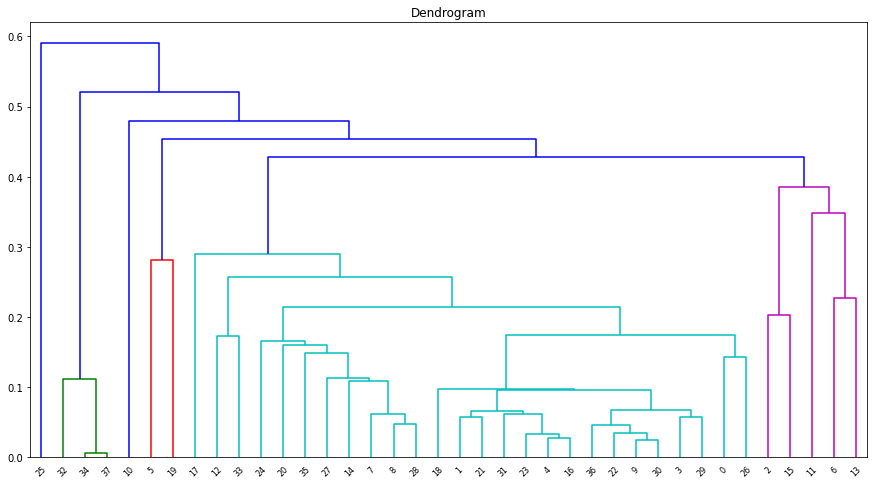

In [ ]:
## clustering 적용하고 덴드로그램 ()
import scipy.cluster.hierarchy as shc
plt.figure(figsize = (15,8))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(df2_cluster, method = 'single')) ## linkage 고민되었는데 이상치 영향 적을 것 같아서 single로 설정

부언) dendrogram을 봤을 때 정상적인 추이가 있고, 특정 국가들만 비정상적인 형태의 코로나 확진자 추세를 보였던 것 같다. 대다수의 형태와 다르게 나타났던 국가들의 시계열 그래프를 확인하고, 코로나 방역과 관련해 벤치마킹/타산지석으로 삼을 수 있음

## 통계파트 3번 (교차분석)
아래 이미지와 같은 학과별 학점 분포 인원수 표가 있다. 학과와 성적이 관계있는지를 검정하라
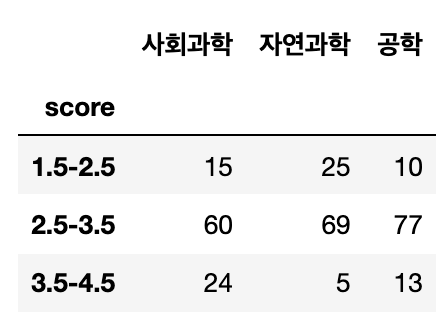
1. 귀무가설, 연구가설 세우기
2. 학과와 성적이 독립일 경우의 기댓값을 구하시오
3. 검정통계량 구하고 연구가설의 채택여부 작성

1. 학과와 성적의 연관성을 파악하기 위해서는 카이제곱검정의 독립성 검정을 이용해야 한다. 이 때 귀무가설과 연구가설은 다음과 같다.   
귀무가설: 학과와 성적은 독립이다. 
연구가설: 학과와 성적은 독립이 아니다. 
2. 학과와 성적이 독립인 경우, 랜덤한 상태로 전체 도수가 균일하게 분배된다. 독립인 경우의 기대값은 python 함수를 사용하여 아래와 같이 계산할 수 있다. 

In [ ]:
from scipy.stats import chi2_contingency
testdata3 = np.array([[15, 25, 10], [60, 69, 77], [24, 5, 13]])
g, p, dof, expctd = chi2_contingency(testdata3, lambda_="log-likelihood")  ##순서대로 통계량, p값, 자유도, 독립상태의 기대값
expctd

array([[16.61073826, 16.61073826, 16.77852349],
       [68.43624161, 68.43624161, 69.12751678],
       [13.95302013, 13.95302013, 14.09395973]])

3. 2번의 코드에 이어서 카이제곱 독립성 검정을 수행한 검정통계량은 아래와 같다. 

In [ ]:
g

22.655415564321043

또한 귀무가설 아래에서의 p값은 아래와 같은데, 약 0.0001로 유의수준 5%에서 귀무가설이 기각됨을 알 수 있다. 
따라서 학과와 성적 간에는 연관성이 존재한다. 

In [ ]:
p

0.00014836154552323375